# Import some Libraries

In [1]:
import os
import time
from datetime import datetime

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso   
from sklearn.svm import SVR

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import r2_score

# for mape
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

# for smape
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# per hour mae
def per_hour_mae(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.abs(y_true - y_pred)

import warnings
warnings.filterwarnings("ignore")

# Target site testing without domain adaptation by airport pretrained model

In [2]:
def target_direct_testing(name_list):
    '''
    Input:- give input and output pairs at different site with base+derived features
    Output:- calibrated results at different sites without domain adaptation at target sites
    '''
    # base+derived features path
    base_derived_data_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\data\base_derived_features'
    
    # source site name
    source_site = 'Airport'
    
    for name in name_list:
        
        print('Site Name:', name)
        # read data files
        df_name = pd.read_csv(base_derived_data_path + '/base_derived_innu_outu_startupA_'+name+'.csv')
        
        # convert date into standard format
        df_name.Date = pd.to_datetime(df_name.Date,dayfirst=True)
        
        # prepare training, validation and testing data pairs
        a = 168 # 2days data for training
        b = 336 # 1 week data for validation
        c = 1056 # 1 month data for testing
        d = df_name.shape[0] # next data for testing
        
        # prepare set for train, val and test date
        train_date = df_name.iloc[120:a,0:1].values
        val_date = df_name.iloc[a:b,0:1].values
        test_date1 = df_name.iloc[b:c,0:1].values
        test_date2 = df_name.iloc[c:d,0:1].values
        
        # prepare set for train, val and test uncalibrated PM2.5
        train_lowcost = df_name.iloc[120:a,2:3].values
        val_lowcost = df_name.iloc[a:b,2:3].values
        test_lowcost1 = df_name.iloc[b:c,2:3].values
        test_lowcost2 = df_name.iloc[c:d,2:3].values
        
        # normalize the input features
        innu = df_name.drop(['Date','PM25','hour','hour_sin','hour_cos'],axis=1)
        outu = df_name[['Date','PM25','hour_sin','hour_cos']]
        innu_scaled = StandardScaler().fit_transform(innu.values)
        innu_scaled_df = pd.DataFrame(innu_scaled, index=innu.index, columns=innu.columns)
        df1 = pd.concat([outu,innu_scaled_df],axis=1)
        innu1 = df1.drop(['Date','PM25'],axis=1)
        outu1 = df1[['PM25']]
        innu_f1 = innu1.iloc[:,:].values
        outu_f1 = outu1.iloc[:,:].values
        
        # prepare training, validation and testing data pairs in 2D
        X_train = innu_f1[120:a,:].astype(np.float32)
        y_train = outu_f1[120:a,:].astype(np.float32)
        X_val = innu_f1[a:b,:].astype(np.float32)
        y_val = outu_f1[a:b,:].astype(np.float32)
        X_test1 = innu_f1[b:c,:].astype(np.float32)
        y_test1 = outu_f1[b:c,:].astype(np.float32)
        X_test2 = innu_f1[c:d,:].astype(np.float32)
        y_test2 = outu_f1[c:d,:].astype(np.float32)
        
        # prepare training, validation and testing data pairs in 1D
        X_train_1d = X_train.reshape(X_train.shape[0],X_train.shape[1])
        y_train_1d = y_train.reshape(y_train.shape[0],)
        X_val_1d = X_val.reshape(X_val.shape[0],X_val.shape[1])
        y_val_1d = y_val.reshape(y_val.shape[0],)
        X_test1_1d = X_test1.reshape(X_test1.shape[0],X_test1.shape[1])
        y_test1_1d = y_test1.reshape(y_test1.shape[0],)
        X_test2_1d = X_test2.reshape(X_test2.shape[0],X_test2.shape[1])
        y_test2_1d = y_test2.reshape(y_test2.shape[0],)
        
        # Uncalibrated performance
        unc_accuracy = pd.DataFrame({
        'Parameters': ['R2_train','MAPE(%)_train','SMAPE(%)_train','R2_val','MAPE(%)_val','SMAPE(%)_val',
                   'R2_test1','MAPE(%)_test1','SMAPE(%)_test1','R2_test2','MAPE(%)_test2','SMAPE(%)_test2'],
         'unc': [ r2_score(y_train,train_lowcost),mape(y_train,train_lowcost),smape(y_train,train_lowcost), 
                 r2_score(y_val,val_lowcost),mape(y_val,val_lowcost), smape(y_val,val_lowcost),
                 r2_score(y_test1,test_lowcost1),mape(y_test1,test_lowcost1),smape(y_test1,test_lowcost1),
                 r2_score(y_test2,test_lowcost2),mape(y_test2,test_lowcost2),smape(y_test2,test_lowcost2)]})
        unc_accuracy=unc_accuracy.transpose()
        
        # base model path
        base_model_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\models\base+derived_features_model'
        
        # Calibration using LinearRegression (lr)
        lr = pickle.load(open(base_model_path + '\lr_model_' + source_site + '.sav', 'rb'))
        lr_pred_train = lr.predict(X_train_1d)
        lr_pred_val = lr.predict(X_val_1d)
        lr_pred_test1 = lr.predict(X_test1_1d)
        lr_pred_test2 = lr.predict(X_test2_1d)
        
        # Calibrated results using lr
        lr_accuracy = pd.DataFrame({
        'lr': [ r2_score(y_train_1d,lr_pred_train),mape(y_train_1d,lr_pred_train),smape(y_train_1d,lr_pred_train), 
                 r2_score(y_val_1d,lr_pred_val),mape(y_val_1d,lr_pred_val), smape(y_val_1d,lr_pred_val),
                 r2_score(y_test1_1d,lr_pred_test1),mape(y_test1_1d,lr_pred_test1),smape(y_test1_1d,lr_pred_test1),
                 r2_score(y_test2_1d,lr_pred_test2),mape(y_test2_1d,lr_pred_test2),smape(y_test2_1d,lr_pred_test2)]})
        lr_accuracy=lr_accuracy.transpose()
        
        # Calibration using Support Vector Regression (svr)
        svr = pickle.load(open(base_model_path + '\svr_model_' + source_site + '.sav', 'rb'))
        svr_pred_train = svr.predict(X_train_1d)
        svr_pred_val = svr.predict(X_val_1d)
        svr_pred_test1 = svr.predict(X_test1_1d)
        svr_pred_test2 = svr.predict(X_test2_1d)
        
        # Calibrated results using svr
        svr_accuracy = pd.DataFrame({
        'svr': [ r2_score(y_train_1d,svr_pred_train),mape(y_train_1d,svr_pred_train),smape(y_train_1d,svr_pred_train), 
                 r2_score(y_val_1d,svr_pred_val),mape(y_val_1d,svr_pred_val), smape(y_val_1d,svr_pred_val),
                 r2_score(y_test1_1d,svr_pred_test1),mape(y_test1_1d,svr_pred_test1),smape(y_test1_1d,svr_pred_test1),
                 r2_score(y_test2_1d,svr_pred_test2),mape(y_test2_1d,svr_pred_test2),smape(y_test2_1d,svr_pred_test2)]})
        svr_accuracy=svr_accuracy.transpose()
        
        # Calibration using Elastic Net Regression (enr)
        enr = pickle.load(open(base_model_path + '\enr_model_' + source_site + '.sav', 'rb'))
        enr_pred_train = enr.predict(X_train_1d)
        enr_pred_val = enr.predict(X_val_1d)
        enr_pred_test1 = enr.predict(X_test1_1d)
        enr_pred_test2 = enr.predict(X_test2_1d)
        
        # Calibrated results using enr
        enr_accuracy = pd.DataFrame({
        'enr': [ r2_score(y_train_1d,enr_pred_train),mape(y_train_1d,enr_pred_train),smape(y_train_1d,enr_pred_train), 
                 r2_score(y_val_1d,enr_pred_val),mape(y_val_1d,enr_pred_val), smape(y_val_1d,enr_pred_val),
                 r2_score(y_test1_1d,enr_pred_test1),mape(y_test1_1d,enr_pred_test1),smape(y_test1_1d,enr_pred_test1),
                 r2_score(y_test2_1d,enr_pred_test2),mape(y_test2_1d,enr_pred_test2),smape(y_test2_1d,enr_pred_test2)]})
        enr_accuracy=enr_accuracy.transpose()
        
        # Calibration using Ridge Regression (rr)
        rr = pickle.load(open(base_model_path + '/rr_model_' + source_site + '.sav', 'rb'))
        rr_pred_train = rr.predict(X_train_1d)
        rr_pred_val = rr.predict(X_val_1d)
        rr_pred_test1 = rr.predict(X_test1_1d)
        rr_pred_test2 = rr.predict(X_test2_1d)
        
        # Calibrated results using rr
        rr_accuracy = pd.DataFrame({
        'rr': [ r2_score(y_train_1d,rr_pred_train),mape(y_train_1d,rr_pred_train),smape(y_train_1d,rr_pred_train), 
                 r2_score(y_val_1d,rr_pred_val),mape(y_val_1d,rr_pred_val), smape(y_val_1d,rr_pred_val),
                 r2_score(y_test1_1d,rr_pred_test1),mape(y_test1_1d,rr_pred_test1),smape(y_test1_1d,rr_pred_test1),
                 r2_score(y_test2_1d,rr_pred_test2),mape(y_test2_1d,rr_pred_test2),smape(y_test2_1d,rr_pred_test2)]})
        rr_accuracy=rr_accuracy.transpose()
        
        # Calibration using Lasso Regression (lar)
        lar = pickle.load(open(base_model_path + '\lar_model_' + source_site + '.sav', 'rb'))
        lar_pred_train = lar.predict(X_train_1d)
        lar_pred_val = lar.predict(X_val_1d)
        lar_pred_test1 = lar.predict(X_test1_1d)
        lar_pred_test2 = lar.predict(X_test2_1d)
        
        # Calibrated results using lar 
        lar_accuracy = pd.DataFrame({
        'lar': [ r2_score(y_train_1d,lar_pred_train),mape(y_train_1d,lar_pred_train),smape(y_train_1d,lar_pred_train), 
                 r2_score(y_val_1d,lar_pred_val),mape(y_val_1d,lar_pred_val), smape(y_val_1d,lar_pred_val),
                 r2_score(y_test1_1d,lar_pred_test1),mape(y_test1_1d,lar_pred_test1),smape(y_test1_1d,lar_pred_test1),
                 r2_score(y_test2_1d,lar_pred_test2),mape(y_test2_1d,lar_pred_test2),smape(y_test2_1d,lar_pred_test2)]})
        lar_accuracy=lar_accuracy.transpose()
        
        
        # Calibration using Dense Neural Network (dnn)
        dnn = models.load_model(base_model_path + '\dnn_model_' + source_site + '.h5')
        dnn_pred_train = dnn.predict(X_train)
        dnn_pred_val = dnn.predict(X_val)
        dnn_pred_test1 = dnn.predict(X_test1)
        dnn_pred_test2 = dnn.predict(X_test2)
        
        # Calibrated results using dnn 
        dnn_accuracy = pd.DataFrame({
        'dnn': [r2_score(y_train,dnn_pred_train),mape(y_train,dnn_pred_train),smape(y_train,dnn_pred_train), 
          r2_score(y_val,dnn_pred_val),mape(y_val,dnn_pred_val), smape(y_val,dnn_pred_val),
          r2_score(y_test1,dnn_pred_test1),mape(y_test1,dnn_pred_test1),smape(y_test1,dnn_pred_test1),
          r2_score(y_test2,dnn_pred_test2),mape(y_test2,dnn_pred_test2),smape(y_test2,dnn_pred_test2)]})
        dnn_accuracy=dnn_accuracy.transpose()
        
        # save the entire model results
        result_name = pd.concat([unc_accuracy,lr_accuracy,svr_accuracy,enr_accuracy,rr_accuracy,lar_accuracy,dnn_accuracy])
        
        # path of direct target sites testing calibrated results without domain adaptation
        target_results_without_da_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\results\targrt_site_testing_results_without_domain_adaptation'
        result_name.to_csv(target_results_without_da_path+  '/target_without_da_acc_tables_startupA_'+ name + '.csv', index=False)
        
        # calibrated and uncalibrated PM2.5 visualization for testing1 period
        fig, ax = plt.subplots(1,1,figsize = (15,5), sharex = False,sharey=True)
        plt.plot(test_date1,test_lowcost1, lw =1.5, color = 'brown',label='Uncalibrated')
        plt.plot(test_date1,y_test1, lw =1.5, color = 'k',label='Reference')
        plt.plot(test_date1,lr_pred_test1, lw =1.5, color = 'r',label='LR (Calibrated)')
        plt.plot(test_date1,dnn_pred_test1, lw =1.5, color = 'b',label='DNN (Calibrated)')
        locator=MaxNLocator(prune='both',nbins=3)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Date',fontsize = 30)
        plt.ylabel('PM$_{2.5}$ ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([test_date1[0],test_date1[-1]])
        plt.ylim([0,300])
        plt.title(name,fontsize = 30,x=0.8,y=0.8)
        plt.savefig(target_results_without_da_path+  '/target_results_without_da_cal_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')
        
        # Accumulated Graphs based on hourly MAE for testing 1 period
        lr_hourly_mae = per_hour_mae(y_test1_1d,lr_pred_test1).reshape(y_test1_1d.shape[0],1)
        svr_hourly_mae = per_hour_mae(y_test1_1d,svr_pred_test1).reshape(y_test1_1d.shape[0],1)
        enr_hourly_mae = per_hour_mae(y_test1_1d,enr_pred_test1).reshape(y_test1_1d.shape[0],1)
        rr_hourly_mae = per_hour_mae(y_test1_1d,rr_pred_test1).reshape(y_test1_1d.shape[0],1)  
        lar_hourly_mae = per_hour_mae(y_test1_1d,lar_pred_test1).reshape(y_test1_1d.shape[0],1)
        dnn_hourly_mae = per_hour_mae(y_test1,dnn_pred_test1).reshape(y_test1.shape[0],1)
        
        def accumulative_mae(hourly_mae):
            """
            Convert hourly mae into accumulative format i.e.,
            mae at hour 2 is the sum of mae at hour 1 and hour 2
            """
            no_of_hour = 720
            mae = np.zeros([no_of_hour,1])
            for i in range(no_of_hour):
                mae[i] = mae[i-1] + hourly_mae[i]
            return mae
        lr_accumulative_mae = accumulative_mae(lr_hourly_mae)
        svr_accumulative_mae = accumulative_mae(svr_hourly_mae)
        enr_accumulative_mae = accumulative_mae(enr_hourly_mae)
        rr_accumulative_mae = accumulative_mae(rr_hourly_mae)
        lar_accumulative_mae = accumulative_mae(lar_hourly_mae)
        dnn_accumulative_mae = accumulative_mae(dnn_hourly_mae)
        
        # Accumulated MAE Visualization
        fig, ax = plt.subplots(1,1,figsize = (15,4), sharex = False,sharey=True)
        hour = np.arange(1,721,1)
        plt.plot(hour,lr_accumulative_mae, lw =1.5, color = 'r',label='LR')
        plt.plot(hour,svr_accumulative_mae, lw =1.5, color = 'olive',label='SVR')
        plt.plot(hour,enr_accumulative_mae, lw =1.5, color = 'y',label='ENR')
        plt.plot(hour,rr_accumulative_mae, lw =1.5, color = 'c',label='RR')
        plt.plot(hour,lar_accumulative_mae, lw =1.5, color = 'm',label='LAR')
        plt.plot(hour,dnn_accumulative_mae, lw =1.5, color = 'b',label='DNN')
        locator=MaxNLocator(prune='both',nbins=4)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Hours',fontsize = 30)
        plt.ylabel('MAE ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([hour[0],hour[-1]])
        plt.ylim([0,7000])
        plt.title(name,fontsize = 30,x=0.5,y=0.8)
        plt.savefig(target_results_without_da_path+  '/target_results_without_da_mae_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')

# Get the calibrated results for different site of startup's A

Site Name: Borivali
Site Name: Kalyan
Site Name: Mahape
Site Name: Nerul
Site Name: Powai
Site Name: Vileparle
Site Name: Worli


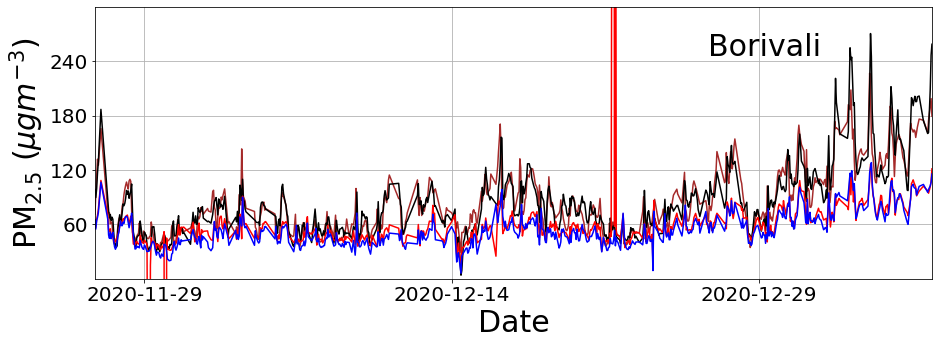

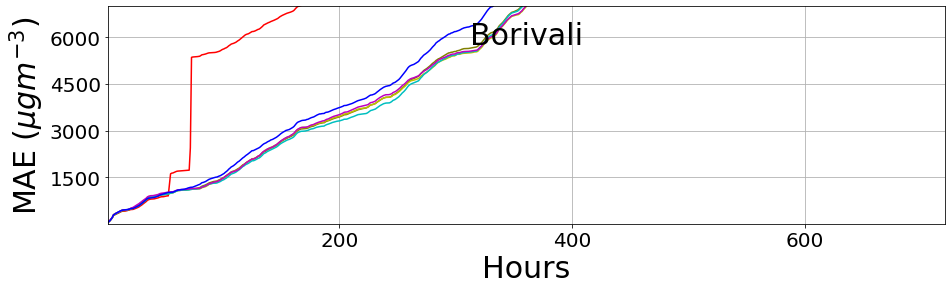

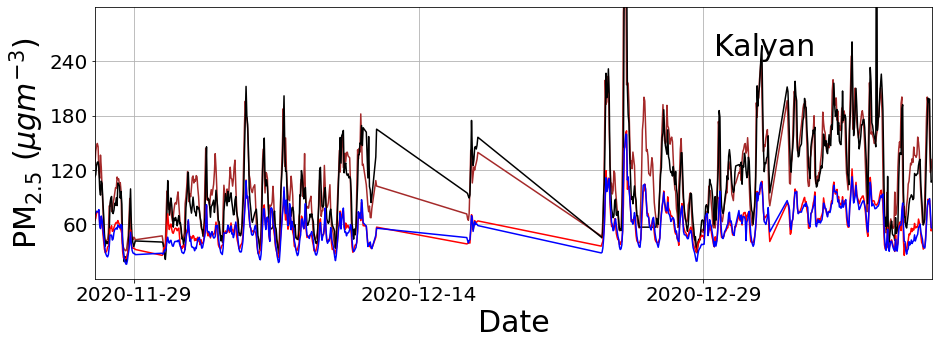

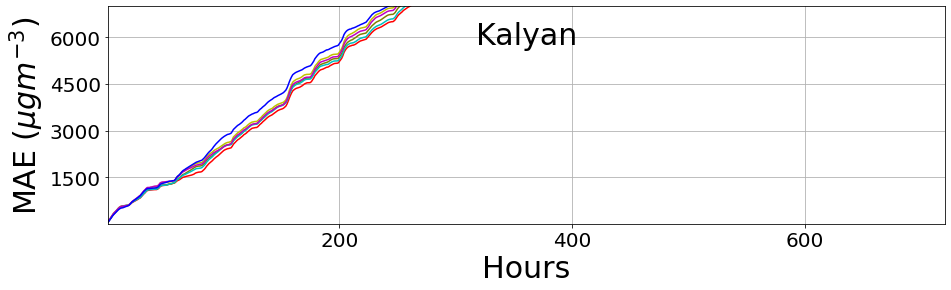

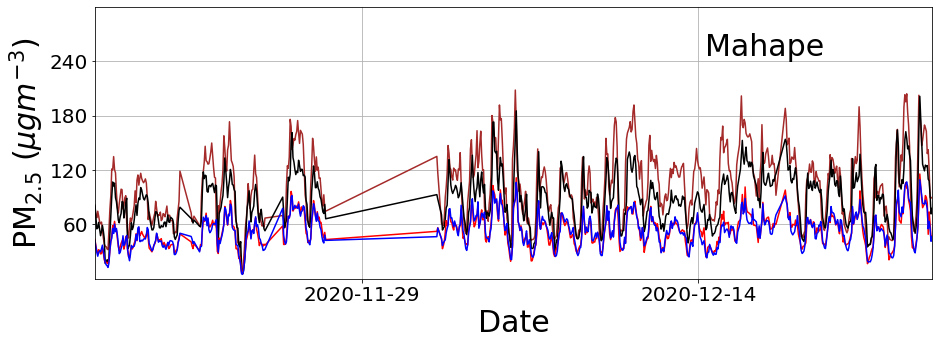

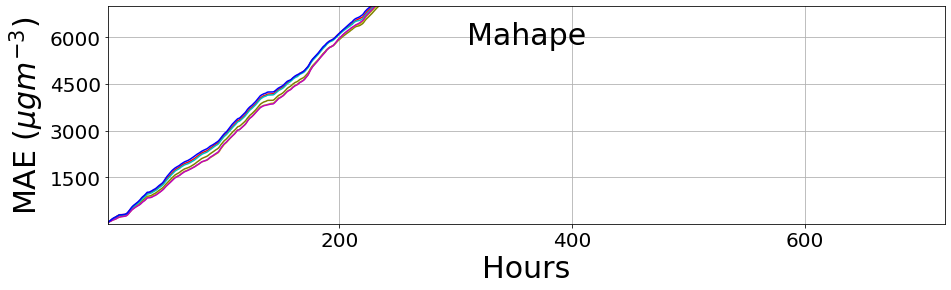

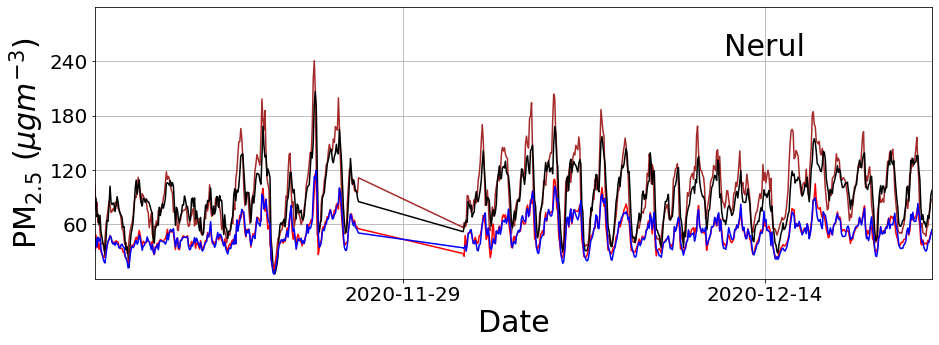

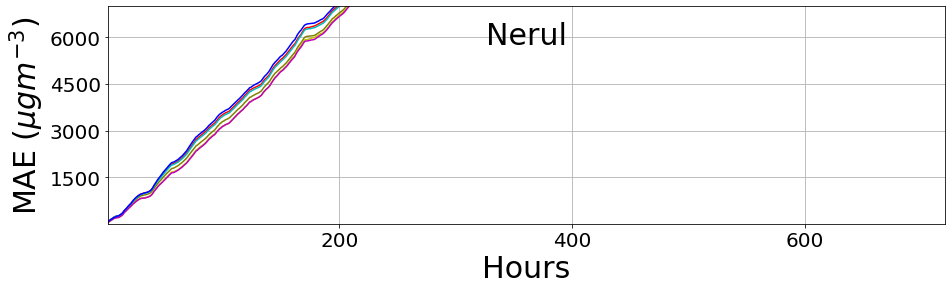

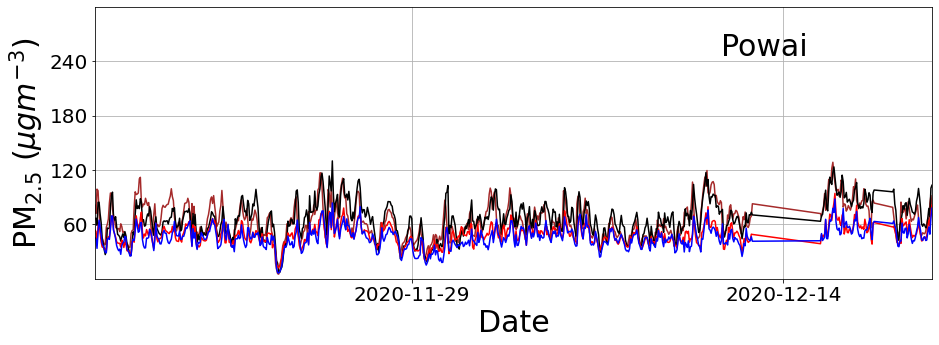

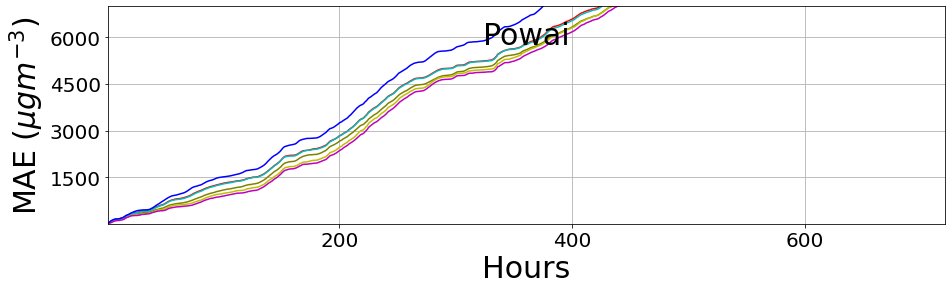

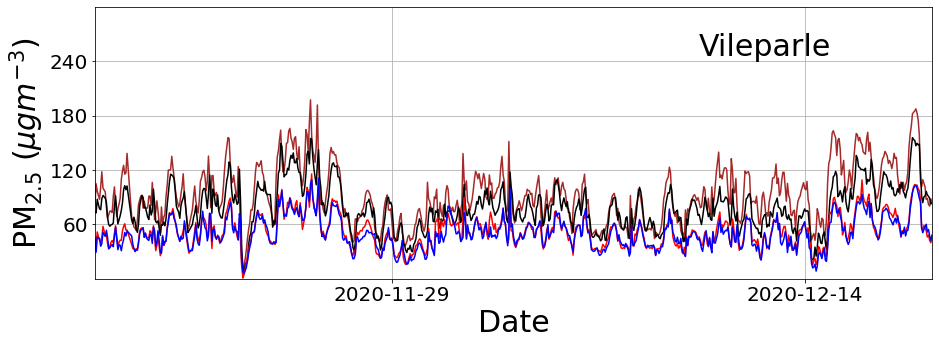

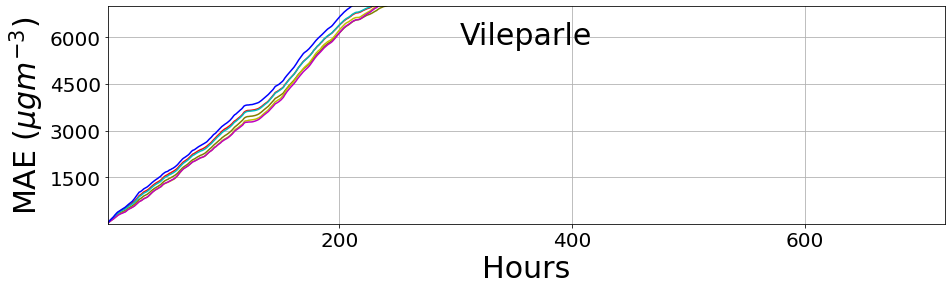

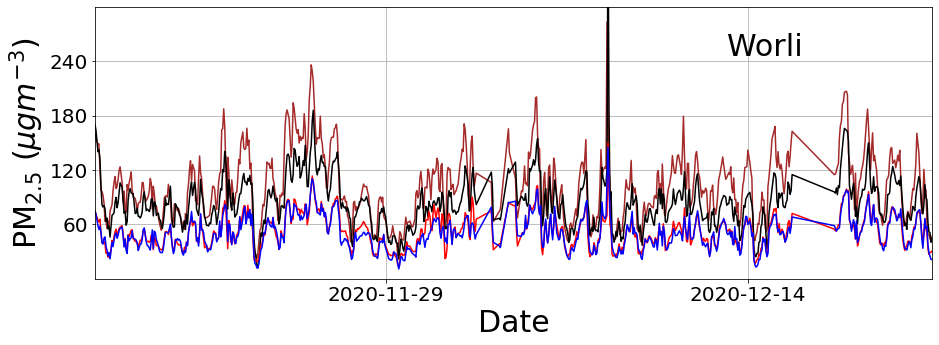

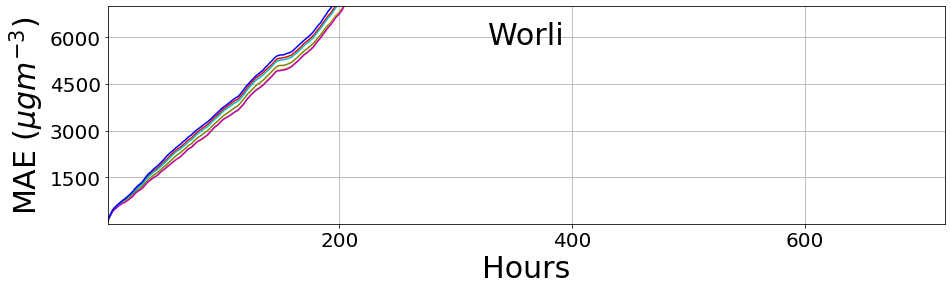

In [3]:
name_list = ['Borivali','Kalyan','Mahape','Nerul','Powai','Vileparle','Worli']
target_direct_testing(name_list)